Author: Lijing Wang (lijing52@stanford.edu), 2022 & 
Alex Miltenberger (ammilten@stanford.edu), 2022


In [1]:
from scipy.constants import G, pi
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

import scipy.stats as st

from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import seaborn as sns

np.random.seed(1)


In [2]:
x = np.linspace(-200,200,21)

def g(m):
    rho = m[:,0][:,np.newaxis]
    a = m[:,1][:,np.newaxis]
    z = m[:,2][:,np.newaxis]    
    
    gz = (4/3)*G*np.pi*(a**3)*rho*z / np.power((x**2+z**2),(3/2)) * 1e5
    return gz  


def sample(distr, N, kind=None):
    
    if kind == 'multivariate':
        samples = distr.rvs(N)
        
    elif kind == 'list':
        samples = [distr[i].rvs(N) for i in range(len(distr))]
        samples = np.vstack(samples).T
        
    elif kind == 'kde':
        samples = distr.resample(N).T
        
    else:
        print('DID NOT RECOGNIZE TYPE')   
        
    return samples

def BayesFactor(push_numerator, push_denominator, obs, N):
    # Sample push_numerator (m)
    
    # Sample push_denominator (m)
    
    # Forward simulation
    
    # Run both samples through obs (d)
    
    # Return B = Mean obs 1 / Mean obs 2
    
    pass
        

def SMC(initial_proposal, measurement_density, numIter, Nsamples, KDEsamples=None):
    '''
    initial_proposal: list of scipy.stats.rv_continuous or scipy.stats.gaussian_kde
    measurement_density: scipy.stats.rv_continuous
    Niter: 
    Nsamples:
    KDEsamples: number of samples for KDE estimation
    '''
    
    # Initialize proposal
    proposal = initial_proposal
    proposal_type = 'list'
    
    # Sample measurement density
    d_obs_samples = sample(measurement_density, Nsamples, kind='multivariate')
    
    if KDEsamples is None:
        KDEsamples = 2000
        
    output = {
        'm_samples':[], 
        'd_samples':[], 
        'S_samples':[],
        'pca':[],
        'weights':[],
        'proposal':[],
        'd_obs_samples':[],
        'S_obs_samples':[]
    }
    
    Iter = 0
    while Iter < numIter:
        print('Iteration {}'.format(Iter+1))
        # Sampling & fowrard model
        m_prop_samples = sample(proposal, Nsamples, kind=proposal_type)
        d_prop_samples = g(m_prop_samples)
        
        # PCA to create S (summary stat. function)
        pca = PCA(n_components=2).fit(d_prop_samples)
        S_prop_samples = pca.transform(d_prop_samples)
        S_obs_samples = pca.transform(d_obs_samples)
        
        # Low-dim density estimation        
        S_prop_density = st.gaussian_kde(S_prop_samples[:KDEsamples,:].T)
        S_obs_density = st.gaussian_kde(S_obs_samples[:KDEsamples,:].T)
    
        # Weights & proposal updating
        weights = S_obs_density.evaluate(S_prop_samples.T) / S_prop_density.evaluate(S_prop_samples.T)
        proposal = st.gaussian_kde(m_prop_samples.T, weights=weights, bw_method='silverman')
        
        Iter += 1
        proposal_type = 'kde'
        
        output['m_samples'].append(m_prop_samples)
        output['d_samples'].append(d_prop_samples)
        output['S_samples'].append(S_prop_samples)
        output['d_obs_samples'].append(d_obs_samples)
        output['S_obs_samples'].append(S_obs_samples)
        output['weights'].append(weights)
        output['proposal'].append(proposal)
        output['pca'].append(pca)
        
    return proposal, output

def Rejection(proposal, target, N, maxIter_factor=5, kind='kde'):
    Nprop = N*maxIter_factor
    m_proposal_samples = sample(proposal, Nprop, kind='kde')
    d_proposal_samples = g(m_proposal_samples)
    
    p_proposal_samples = target.pdf(d_proposal_samples)
    pmax = np.max(p_proposal_samples)
    p_proposal_samples = p_proposal_samples / pmax
    
    u = np.random.rand(Nprop)
    inds = p_proposal_samples > u
    
    m_samples = m_proposal_samples[inds,:]
    if m_samples.shape[0] > N:
        m_samples = m_samples[:N,:]
    if m_samples.shape[0] < N:
        print('WARNING: only found {} samples (target samples = {})'.format(m_samples.shape[0], N))
    
    return m_samples
    


In [3]:
m_true = np.array([[2000, 100, 125]])

gz_obs_true = g(m_true)[0,:]


initial_proposal = [
    st.uniform(loc=1000, scale=6000), 
    st.uniform(loc=70, scale=130), 
    st.uniform(loc=25, scale=175)
]


In [4]:
Niter = 3
Nsamples = 8000

sigma = 0.05
np.random.seed(1)
gz_obs = st.multivariate_normal(mean=gz_obs_true, cov=np.diag((gz_obs_true*sigma)**2)).rvs(1)
measurement_density = st.multivariate_normal(mean=gz_obs, cov=np.diag((gz_obs*sigma)**2))
obs_d = measurement_density.rvs(Nsamples)

posterior, S = SMC(initial_proposal, measurement_density, Niter, Nsamples, KDEsamples=Nsamples)


prior_samples = sample(initial_proposal, Nsamples, kind='list')
posterior_samples = sample(posterior, Nsamples, kind='kde')

nn = Nsamples
cols = [r'$\rho$ (kg/m$^3$)',r'$a$ (m)',r'$z$ (m)']
prior_samples_df = pd.DataFrame(prior_samples[:nn], columns=cols)
posterior_samples_df = pd.DataFrame(posterior_samples[:nn,:], columns=cols)
true_df = pd.DataFrame(m_true, columns=cols)



Iteration 1
Iteration 2
Iteration 3


<ipython-input-5-66480199bdc3>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


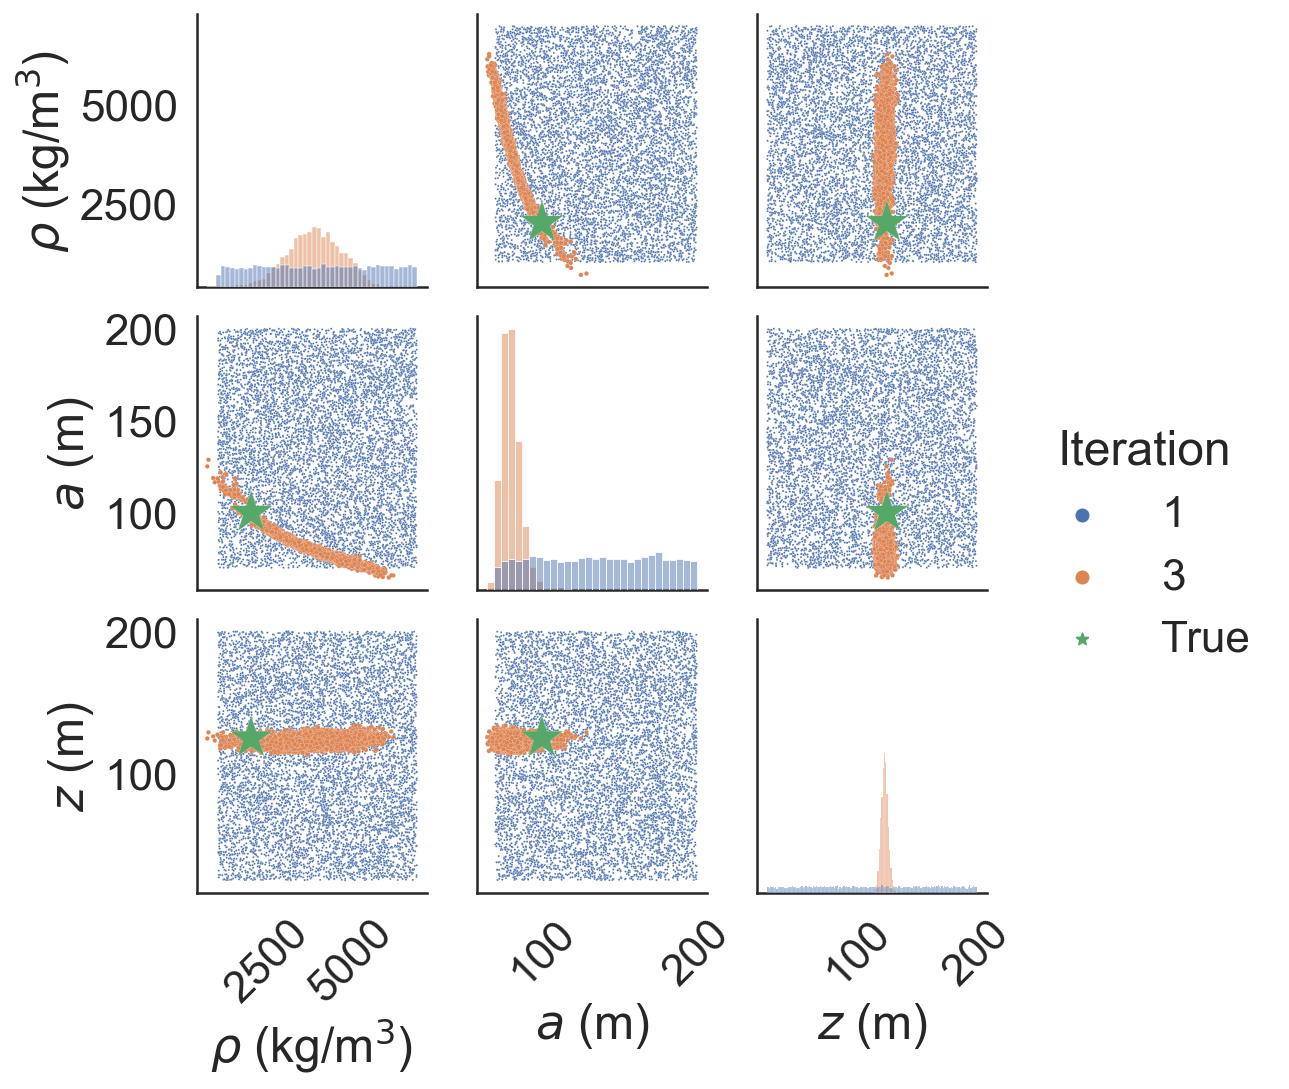

In [5]:
combined = pd.concat([
    prior_samples_df.assign(Iteration='1', size=1, marker='o'),
    posterior_samples_df.assign(Iteration='3', size=5, marker='o'), 
#     final_samples_df.assign(dataset='Rejection', size=5, marker='o'),
    true_df.assign(Iteration='True', size=500, marker='*')     
])
markers = {'1': 'o', '3': 'o', 'True': '*'}
# sizes = {'Prior': 5, 'Proposal': 5, 'Rejection': 5, 'True': 500}

sns.set(font_scale = 2)
sns.set_style(style='white')
h = sns.pairplot(combined[cols+['Iteration']], kind = 'scatter', diag_kind='hist', plot_kws={"s": combined['size']}, markers=markers, hue="Iteration")
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



In [6]:
Niter = 3
Nsamples = 8000
sigma = 0.015
np.random.seed(1)
gz_obs = st.multivariate_normal(mean=gz_obs_true, cov=np.diag((gz_obs_true*sigma)**2)).rvs(1)
measurement_density = st.multivariate_normal(mean=gz_obs, cov=np.diag((gz_obs*sigma)**2))
obs_d2 = measurement_density.rvs(Nsamples)

posterior, S2 = SMC(initial_proposal, measurement_density, Niter, Nsamples, KDEsamples=Nsamples)


prior_samples = sample(initial_proposal, Nsamples, kind='list')
posterior_samples = sample(posterior, Nsamples, kind='kde')

prior_samples_df = pd.DataFrame(prior_samples[:nn], columns=cols)
posterior_samples_df = pd.DataFrame(posterior_samples[:nn,:], columns=cols)
true_df = pd.DataFrame(m_true, columns=cols)



Iteration 1
Iteration 2
Iteration 3


<ipython-input-7-f2dbc1161bf1>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


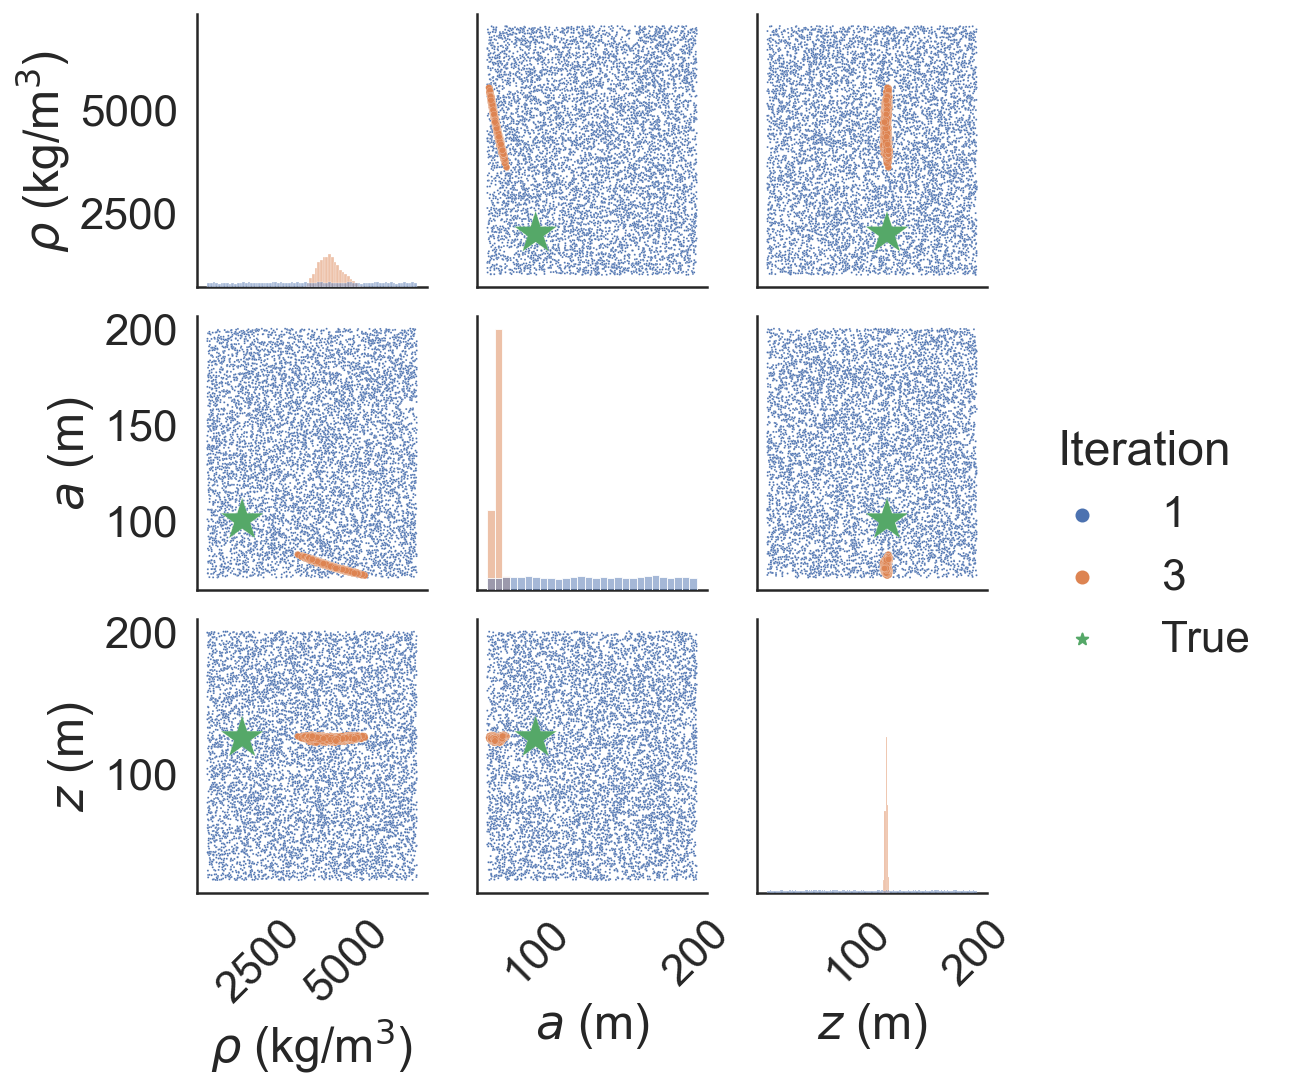

In [7]:
combined = pd.concat([
    prior_samples_df.assign(Iteration='1', size=1, marker='o'),
    posterior_samples_df.assign(Iteration='3', size=10, marker='o'), 
#     final_samples_df.assign(dataset='Rejection', size=5, marker='o'),
    true_df.assign(Iteration='True', size=500, marker='*')     
])
markers = {'1': 'o', '3': 'o', 'True': '*'}
# sizes = {'Prior': 5, 'Proposal': 5, 'Rejection': 5, 'True': 500}

sns.set(font_scale = 2)
sns.set_style(style='white')
h = sns.pairplot(combined[cols+['Iteration']], kind = 'scatter', diag_kind='hist', plot_kws={"s": combined['size']}, markers=markers, hue="Iteration")
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)



Text(0.5, 1.0, '1.5% Measurement Error')

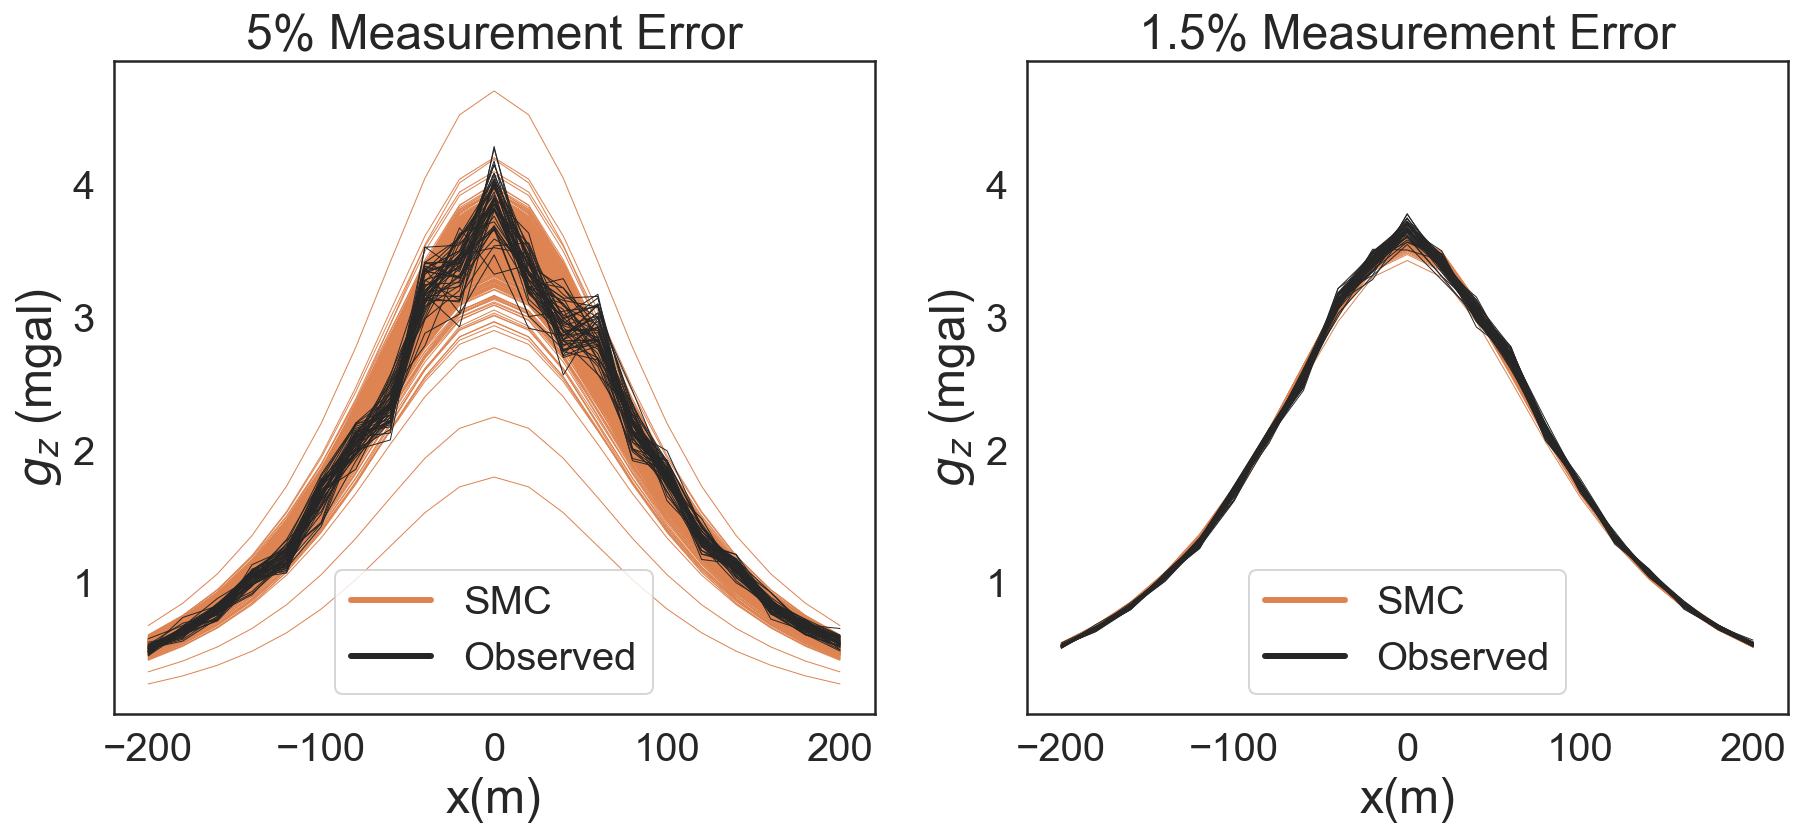

In [8]:
it = 2
fs = 24
ts = 20

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

axs[0].plot(x,S['d_samples'][it][:500,:].T,color= 'C1', linewidth=0.5)
p1 = axs[0].plot(x,S['d_samples'][it][0,:].T,color= 'C1', linewidth=0.5, label='SMC')
axs[0].plot(x,obs_d[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[0].plot(x,obs_d[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[0].set_xlabel('x(m)', fontsize=fs)
axs[0].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[0,0].set_title('Proposal', fontsize=16)
axs[0].tick_params(labelsize=ts)
leg = axs[0].legend(fontsize=ts, loc='lower center')
for L in leg.get_lines():
    L.set_linewidth(3)
yl = axs[0].get_ylim()
axs[0].set_title('5% Measurement Error', fontsize=fs)
    
    
axs[1].plot(x,S2['d_samples'][it][:500,:].T,color= 'C1', linewidth=0.5)
p1 = axs[1].plot(x,S2['d_samples'][it][0,:].T,color= 'C1', linewidth=0.5, label='SMC')
axs[1].plot(x,obs_d2[:50,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5)
p2 = axs[1].plot(x,obs_d2[0,:].T,'-',color = [0.15, 0.15, 0.15, 1], linewidth=0.5, label='Observed')
axs[1].set_xlabel('x(m)', fontsize=fs)
axs[1].set_ylabel(r'$g_z$ (mgal)', fontsize=fs)
# axs[0,0].set_title('Proposal', fontsize=16)
axs[1].tick_params(labelsize=ts)
leg = axs[1].legend(fontsize=ts, loc='lower center')
for L in leg.get_lines():
    L.set_linewidth(3)
axs[1].set_ylim(yl)
axs[1].set_title('1.5% Measurement Error', fontsize=fs)
